<center>
    <img src="https://cellstrat2.s3.amazonaws.com/PlatformAssets/bluewhitelogo.svg" alt="logo" width="200"/>
    <h1>⚡CellStrat Hub API</h1>
    <h2>🧰MLOps Hands-On Workshop🔧</h2>
    <h3>🤔Deploying a Question Answering Model❓</h3>
</center>

# About CellStrat Hub API

CellStrat Hub API is a deployment service to deploy any model as a Serverless Inference API. 

- 🚀 Deploy your Model in under 15 minutes
- 🧰 Simple yet fully customizable deployment without any format requirements and framework agnostic
- 🌐 Model is Deployed as Serverless APIs, which means you only pay for the number of invocations, unlike traditional deployment options where you have to pay for idle time as well.
- 🏗️ APIs are auto-scaled based on traffic, so you don't need to worry about the deployment infrastructure and can focus on building your model.*
- 🐳 All models are deployed using a docker container under the hood, that means you get complete control over your execution environment, allowing you to optimize your inference in low-level languages like C++ also.
- 📡 You can deploy a maximum of 5 APIs for free with 1000 API calls.

Let's understand some basics of API development before we start with the deployment.

## What is a REST API?

![Request Response](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/request-response.jpg)
An API (Application Programming Interface) is a way for two computers to talk to each other. It's similar to accessing a website but instead of using a graphical interface like buttons and forms to interact, we use code to directly access data from the servers. Most Web/HTTP APIs are RESTful, meaning they follow a set of rules and design patterns known as Representational State Transfer or REST. The CellStrat Hub API platform deploys your models as a REST API.

![REST URIs](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/rest-uri.jpg)
RESTful APIs organize data into a set of unique URIs (Uniform Resource Indentifier) that help access different data resources or web services hosted on a particular server. For example, in the endpoint `https://api.cellstrathub.com/alice/my-ml-project`, the `api.cellstrathub.com` part is the server address and `alice/my-ml-project` is a resource on the server that we would like access.

![request format](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/request-format.jpg)
A client can access the web service by making a http request to the server's endpoint. The request message follows a format where it defines the REST method being used, the address of the endpoint, some headers which tell what kind of data it is, the authentication aspects etc and then the body of the message that is actually taken by the service as input.

### `GET` Request

The `GET` method is used to read the data from a resource. In this method, the client doesn't send any message body to the endpoint/server, it just calls it and the server responds with some data. This method is used in Hub API to ping the model and load it memory.

![GET](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/get.jpg)

### `POST` Request

The `POST` method is used to send some data to the server and then get some data in response. This method is used by the client to send the input data to the Hub API model which then performs inference on it and then returns the prediction results to the client in the response.

![POST](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/post.jpg)

## Hub API's Flow of Data

Here's a little animation of how it all comes together when you want to make predictions using your ML model hosted as an API on CellStrat Hub

![API+Data+Flow+Animation.gif](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/API+Data+Flow+Animation.gif)

### Overall Architecture

1. We start by loading the model into memory by sending a `GET` request to the model
2. To make predictions we send the input data using a `POST` request.
3. The API makes the predictions and sends the response back with the result.

![Hub API](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/hub-api.jpg)

# Preparing our Model

To deploy a model, we need to already have a trained model ready. For question-answering, we will use a pretrained transformers model and prepare the inference code so its easy for us to integrate and deploy our code.

We will start by downloading our pretrained model locally by running the cell below

In [ ]:
!wget https://cellstrat-public.s3.amazonaws.com/workshop-files/qa_model.tar.gz
!tar -xzvf qa_model.tar.gz
!rm qa_model.tar.gz

Now let's run our prediction/inference code locally to just make sure everything is working fine.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained("qa_model")
tokenizer = AutoTokenizer.from_pretrained("qa_model")

In [ ]:
context = """The Amazon rainforest (Portuguese: Floresta Amazônica or Amazônia; Spanish: Selva Amazónica, 
Amazonía or usually Amazonia; French: Forêt amazonienne; Dutch: Amazoneregenwoud), also known in English as
Amazonia or the Amazon Jungle, is a moist broadleaf forest that covers most of the Amazon basin of South 
America. This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000 square 
kilometres (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine
nations. The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru
with 13%, Colombia with 10%, and with minor amounts in Venezuela, Ecuador, Bolivia, Guyana, Suriname and 
French Guiana. States or departments in four nations contain "Amazonas" in their names. The Amazon represents 
over half of the planet's remaining rainforests, and comprises the largest and most biodiverse tract of 
tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species."""

question = "Which name is also used to describe the Amazon rainforest in English?"

In [ ]:
# Preprocess the inputs
input_tensors = tokenizer(
    question,
    context,
    max_length=384,
    truncation="only_second",
    padding="max_length", 
    return_tensors='pt'
)

In [ ]:
# Make predictions
with torch.inference_mode():
    output = model(**input_tensors)
    
start_idx = output.start_logits.argmax(dim=-1).item()
end_idx = output.end_logits.argmax(dim=-1).item()

has_answer = True

# Check if the answer is found or not
if start_idx == 0 or end_idx == 0:
    has_answer = False

elif end_idx < start_idx:
    has_answer = False
    
# in case of single word answers
if start_idx == end_idx:
    end_idx = end_idx + 1

In [ ]:
# Decode the answer
if has_answer:
    answer = tokenizer.decode(input_tensors['input_ids'].squeeze()[start_idx: end_idx], 
                              skip_special_tokens=True).strip()
    print('Answer:', answer)
else:
    print('Answer not found')

The predictions from our model seem to be good and we can move on to deploying it 

# Deployment

The CellStrat Hub Workspace comes with a command line tool (CLI) called `hub` which does all of the heavy lifting for deploying our model as an API. This tool can be accessed in the Terminal which is available by clicking on _Blue Plus Button_ on the top-left which opens up the _launcher_ tab where you can click on the Terminal box.

However, we can run terminal commands from notebook cells as well by prepending the command with an exclamation mark `!` so everything is at one place.

### Tip:-

You can use the `--help` flag to view the help menu of any command. Example: `hub --help`, `hub init --help` and so on.

## Initialize

The `hub init <name of project>` command generates the boilerplate code for a Hub API Project. Running this command creates a folder with the name of our project and contains all of the files and folders required for the project. Let's first run the command below and then we will take a tour of all the files generated.

In [ ]:
!hub init extractive-qa

After running the command you can see a tree of files and folder generate which looks something like this,

![hub init](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/hub-init.jpg)

Let's look at each one of those files,
1. `Dockerfile` - Every Hub API deployment package is essentially a docker image which contains the source code and the required libraries when built and deployed. Generally, its all automatically setup for almost all use cases so you don't need to change anything. _But if you are already familiar with docker you can modify the container and optimize it further._
2. `hub_config.json` - This contains some basic configuration of the project like the name of the project and its version. This file is what defines a project as a Hub API project. You don't need to change anything there as well.
3. `model/` - This folder is the place where all our model weights and other large files go. The contents of this folder are stored in a separate network storage and not part for the docker image so the image size remains as minimal as possible. The contents of this folder are available in the `MODEL_DIR` environment variable in your source code.
4. `src/` - This is where all your source code goes in and it already has a few boilerplate files generated.
    - `main.py` - This is the main python file which gets executed whenever a request is made to your model. We will explore it more as we go further.
    - `requirements.txt` - This is where you will list out the libraries required for your model to run.
    - `utils.py` - This is just a module which contains some utility methods for common operations which you might need when working with things like base64 encoded images. You can add your own utilities in this file.

## Integrate

The next step is basically the part where you come in and,
1. Copy your model files in the `model/` folder
2. Add your own code in the `main.py` file
3. List out the libraries needed to run the model

In [ ]:
# Let's start by copying the model files to the right folder
!cp -r qa_model/* extractive-qa/model/

Before we run the commands we change directory to the API project folder as most commands after the init run from inside the project directory.

In [ ]:
cd extractive-qa

Let's breakdown the `main.py` file where our prediction code will be integrated.

![main.py](https://cellstrat-public.s3.amazonaws.com/hub-api-quickstart/assets/main-py.jpg)

The auto-generated file starts with a couple basic imports and a hub_handler decorator which is used on the `inference_handler()` function. This decorator basically indicates that its the function which needs to be executed for inference and adds some additional functionality internally like _ping_ for when we make a `GET` request to load the model in memory.

The `MODEL_DIR` is variable is the path which points to the folder where all the model files reside. We will use this variable when we load our model.

Our main prediction code goes inside the `inference_handler()` function and our inputs will be available in the `input` argument of the function which is essentially a python dictionary (JSON body from the client). In this particular case of QA model, we will accept a dictionary (JSON) which has the question and context keys. Input can be anything that is JSON serializable i.e., all the standard data types like integers, floats, lists/tuples, strings and dictionaries. What format you want to accept the input is entirely upto you. Usually we take the inputs in a dictionary format.

Let's add our own prediction code to the `main.py` file by running the next cell below. As mentioned earlier, we want to perform all the terminal and other manual operations from this notebook itself, so we will modify it  directly from the notebook itself using the `%%writefile` magic function of jupyter. But feel free to open up the .py file yourself and copy paste the code from below (_without the `%%writefile` magic function_)

In [ ]:
%%writefile src/main.py
import os
from hub import hub_handler
import torch # +++ ADDED THIS +++
from transformers import AutoTokenizer, AutoModelForQuestionAnswering # +++ ADDED THIS +++

MODEL_DIR = os.getenv("MODEL_DIR")

model = AutoModelForQuestionAnswering.from_pretrained(MODEL_DIR) # +++ ADDED THIS +++
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR) # +++ ADDED THIS +++

@hub_handler
def inference_handler(inputs, _):
    '''The main inference function which gets triggered when the API is invoked'''
    # +++ ADDED THIS +++
    
    # Preprocess the inputs
    input_tensors = tokenizer(
        inputs['question'],
        inputs['context'],
        max_length=384,
        truncation="only_second",
        padding="max_length", 
        return_tensors='pt'
    )
    
    # Make predictions
    with torch.inference_mode():
        output = model(**input_tensors)

    start_idx = output.start_logits.argmax(dim=-1).item()
    end_idx = output.end_logits.argmax(dim=-1).item()

    has_answer = True

    # Check if the answer is found or not
    if start_idx == 0 or end_idx == 0:
        has_answer = False

    elif end_idx < start_idx:
        has_answer = False

    # in case of single word answers
    if start_idx == end_idx:
        end_idx = end_idx + 1

    # Decode the answer
    if has_answer:
        answer = tokenizer.decode(input_tensors['input_ids'].squeeze()[start_idx: end_idx], 
                                  skip_special_tokens=True).strip()
        
    else:
        answer = "Answer not found"
    
    print('Answer:', answer)
    
    return answer

Now we also add our two main libraries used to the `requirements.txt` file

In [ ]:
%%writefile src/requirements.txt
torch
transformers

Voila! That's it. It was that simple to integrate your own prediction code and model. As you can see the process is framework agnostic and there are no format requirements depending on framework used like pytorch, tensorflow or scikit-learn. Regardless of which library you use, you can deploy any AI model with CellStrat Hub API.

Now the only thing left is to just build our deployment package and deploy it.

## Build and Deploy the Model

We can now build our Inference API package using the `hub build` command. This command will upload the model files to our model storage servers and build the Docker image of our source code and dependencies locally. This can take about 1-2 minutes.

In [ ]:
!hub build

Once everything is built and ready, we can now deploy our API by pushing everything to the cloud using the `hub deploy` command. This can again take 1-2 minutes.

In [ ]:
!hub deploy

And there you go, your API is now live and accessible on the internet. But wait, we don't want our API to fully public as we need to have some control over who uses it and how much is used. To control just that, every API can only be invoked using a API key. In the next and also the last section of this guide, we will test our deployed model API using our API key.

# Testing our API

Based on our choices on how we want the input and the response, our API request-response format should look something like this:

![qa-api](https://cellstrat-public.s3.amazonaws.com/workshop-files/qa-api.jpg)

## API Key Management

As our model is deployed and available as a REST API. You can see it in your [deployment dashboard](https://console.cellstrathub.com/deployments) along with other details about your API usage for the month. In the free-tier every user can make upto 1000 API calls per month to deployed models and every API is secured against an API Key which provides access to a user to call the model. As you are the owner of the API, you can call your API by using your API key which should be available in the _API Key Management_ table in the API Dashboard. Click on _Click here to reveal API Key_ and copy the revealed key. This key is private to you and whenever you use this key the platform knows its you who called it. Don't share this key publicly as someone can misuse this key and finish up your monthly quota. In case it gets leaked you can delete or disable the key using the options available.
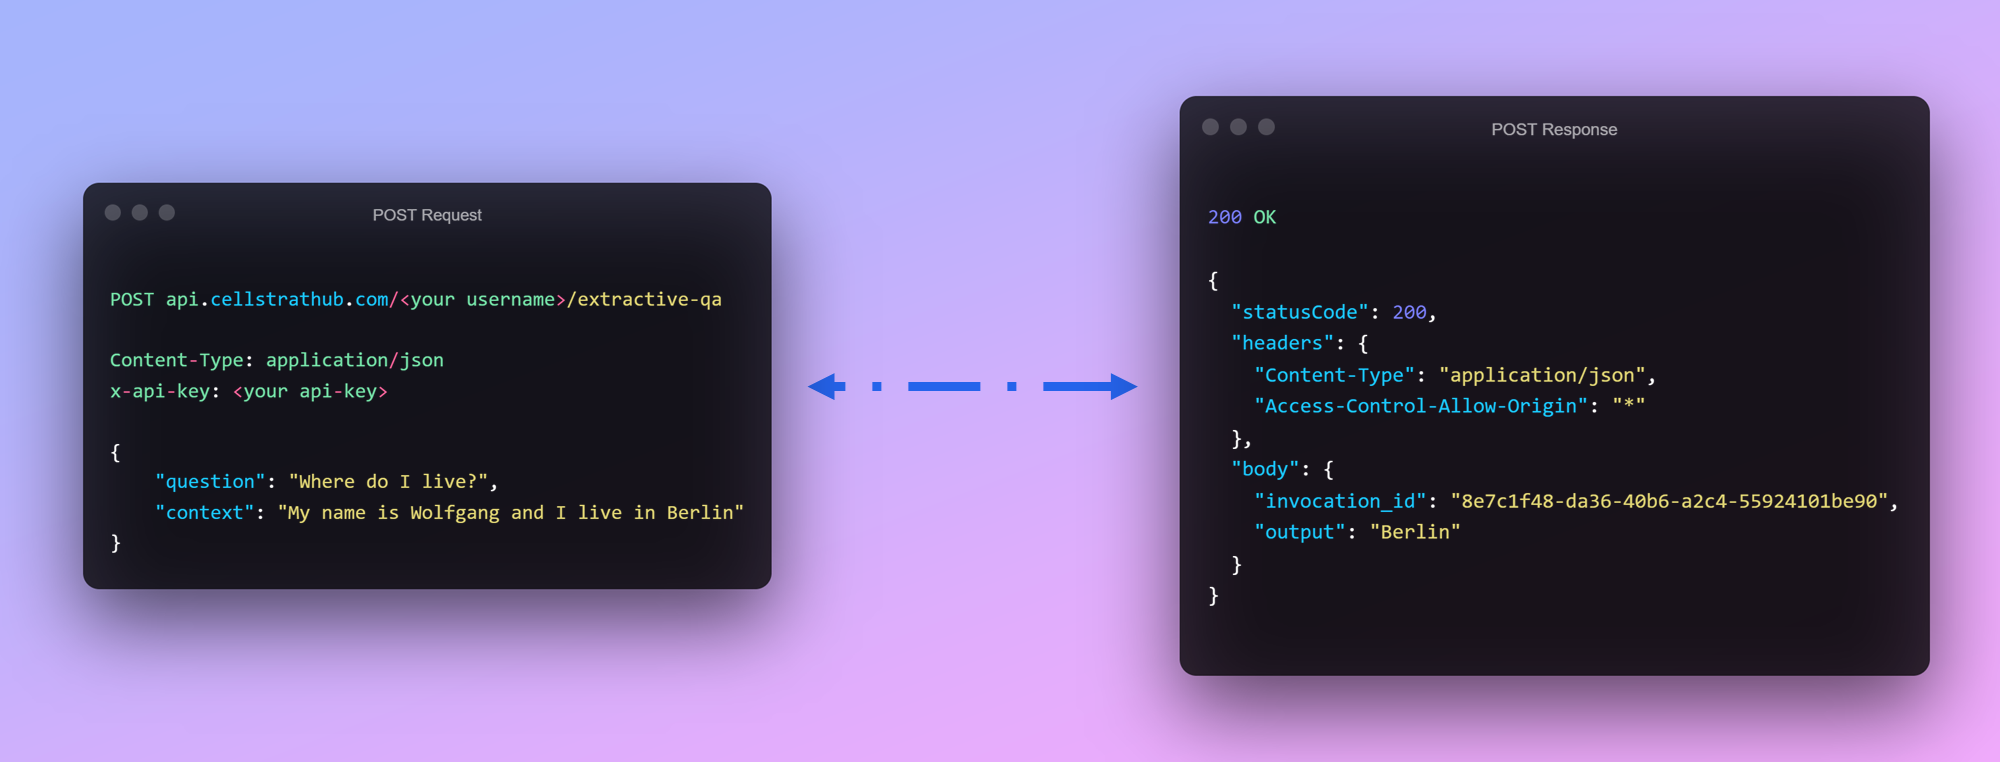

## Invocation

Without further ado, let's test our model. We can call our model from any language and place as long it has internet access. Popularly these APIs are used in conjunction with web applications using javascript. But as we don't have a web app built right now, we will call it using python itself here.

In the code below, replace the necessary values with yours'. You can get the API key from the API Dashboard as mentioned before and you can get your username (if you don't remember) from your [profile](https://console.cellstrathub.com/profile).

In [ ]:
import os
import json
import requests
import base64

# Paste your key and username here
API_KEY = "YOUR API KEY"
USERNAME = "YOUR USERNAME"
API_NAME = "extractive-qa"

# The API endpoint for your Hub API project
endpoint = f"https://api.cellstrathub.com/{USERNAME}/{API_NAME}"

headers = {
  "x-api-key": API_KEY,
  "Content-Type": "application/json"
}

We will start by making a `GET` request to load the model in memory. This request takes a minimum of 20 seconds which is a fixed to give enough time for the model to load asynchronously. You need to run this only once per session.

In [ ]:
# Make a GET request to Ping/Load the Model in Memory
requests.get(endpoint, headers=headers).json()

Now we will make a `POST` request to send our inputs in the body and then get the response back with the predictions.

In [ ]:
context = """The Amazon rainforest (Portuguese: Floresta Amazônica or Amazônia; Spanish: Selva Amazónica, 
Amazonía or usually Amazonia; French: Forêt amazonienne; Dutch: Amazoneregenwoud), also known in English as
Amazonia or the Amazon Jungle, is a moist broadleaf forest that covers most of the Amazon basin of South 
America. This basin encompasses 7,000,000 square kilometres (2,700,000 sq mi), of which 5,500,000 square 
kilometres (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine
nations. The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru
with 13%, Colombia with 10%, and with minor amounts in Venezuela, Ecuador, Bolivia, Guyana, Suriname and 
French Guiana. States or departments in four nations contain "Amazonas" in their names. The Amazon represents 
over half of the planet's remaining rainforests, and comprises the largest and most biodiverse tract of 
tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species."""

question = "Which name is also used to describe the Amazon rainforest in English?"

In [ ]:
%%time
payload = {
    'question': question,
    'context': context
}

# Send the POST request
response = requests.post(endpoint, headers=headers, data=json.dumps(payload)).json()

if response.get('statusCode') == 200:
    # Parse the output
    output = response['body']['output']
else:
    output = response

output